# FLoC cohorts from randomly assigning domains to panel samples

Here we create a comparison/counterfactual to the true panel data.

The same machine_ids for panels are used as for the true data, but where only the sample's demographics are kept.

The visited sets of domains are randomly assigned to panel samples, but where domains are assigned in a way proportional to how they occur in the real panel data.

With this creation, domain visits and therefore cohorts should not be correlated with demographics.


Here's how we do this:

- first take the real panel data, where panel samples are joined with their true sessions data, and data is then limited to samples with >= 7 domains per sample.

- take the distribution of n_domains 

- take the distribution of domains, using each domain's frequency of occurance in the real samples.
i.e. when domains are randomly sampled, their sampling weight is proportional to the number of samples for which they occur in the real panel data.

Create fake panel data where
- each machine,week sample from the real panel is assigned a set of domains by randomly sampling from the distribution of n_domains and the distribution of domains

In [7]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH


Read in the sessions data and join with the panel data as and make the distributions to randomly sample the fake panel data from:
- n_domains distribution
- domains distribution

In [8]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['machine_id', 'domains'], axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


,week,n_domains
0,1,104
1,1,0
2,1,20
3,1,49
4,1,64


In [9]:
all_panels_fpath = '../output/all_panels.csv'
all_panels_df = pd.read_csv(all_panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.drop(['machine_id'], axis=1).head()

read in all panels: 3302090 total rows
520 panels


,week,n_domains,household_income,racial_background,stratify,panel_id
0,1,40,1.0,1.0,"1.0, 1.0",1
1,1,43,1.0,1.0,"1.0, 1.0",1
2,1,147,1.0,1.0,"1.0, 1.0",1
3,1,45,1.0,1.0,"1.0, 1.0",1
4,1,22,1.0,1.0,"1.0, 1.0",1


In [10]:
weeks_machines_domains = weeks_machines_domains_df.set_index(['machine_id','week'])['domains']
all_panels_df['domains'] = all_panels_df.set_index(['machine_id','week']).index.map(weeks_machines_domains)
all_panels_df.drop(['machine_id','domains'], axis=1).head()

,week,n_domains,household_income,racial_background,stratify,panel_id
0,1,40,1.0,1.0,"1.0, 1.0",1
1,1,43,1.0,1.0,"1.0, 1.0",1
2,1,147,1.0,1.0,"1.0, 1.0",1
3,1,45,1.0,1.0,"1.0, 1.0",1
4,1,22,1.0,1.0,"1.0, 1.0",1


In [11]:
n_domains_distribution = all_panels_df.n_domains

In [12]:
# make a list of all domains where the frequency they appear in the list
# is the same as the frequency which they appear in the panel samples
# weekly domains sets
domains_sets = all_panels_df.domains.to_list()
good_domains = [d for domains in domains_sets for d in domains]
# check this matches the n_domains distribution data
assert(len(good_domains) == n_domains_distribution.sum())

In [13]:
# make map for domains distribution
# map: {domain: frequency}
# transform that list into the map: {domain: frequency}
domains_distribution_map = {d: 0 for d in set(good_domains)}
print('%s unique domains' % len(domains_distribution_map))
for d in good_domains:
    domains_distribution_map[d] += 1
# and then trandform this into 2 series:
# domains_list has an item for each domain
# and domains_p is a list of corresponding the probabilities (weights) 
# for each domain in domains_p where the indices match
domains_list = list(domains_distribution_map.keys())
domains_p = [v/len(good_domains) for v in domains_distribution_map.values()]
assert(round((sum(domains_p)), 4) == 1)

3356228 unique domains


what is the fastest way to sample domains?

Answer: using random.sample instead of np.random.choice

In [14]:
%%timeit
# use random to sample without replacement
random.sample(good_domains, k=7)

The slowest run took 10.19 times longer than the fastest. This could mean that an intermediate result is being cached.
32.3 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
%%timeit
# use random to sample without replacement
np.random.choice(domains_list, replace=False, p=domains_p, size=7)

3.2 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
random.seed(0)

def get_random_domains_set(x):
    n_domains = random.choice(n_domains_distribution)
    return set(random.sample(
        good_domains,
        k=n_domains,
    ))

Create alternative version of panel by copying true panel and reassigning domains.

In [17]:
all_panels_random_domains_df = all_panels_df.copy().drop(
    ['n_domains', 'domains'], axis=1
)

In [18]:
all_panels_random_domains_df.head()

,machine_id,week,household_income,racial_background,stratify,panel_id
0,225477651,1,1.0,1.0,"1.0, 1.0",1
1,215623532,1,1.0,1.0,"1.0, 1.0",1
2,186655210,1,1.0,1.0,"1.0, 1.0",1
3,224752776,1,1.0,1.0,"1.0, 1.0",1
4,207687017,1,1.0,1.0,"1.0, 1.0",1


In [19]:
# how long will this take?
print('%s total samples across panels' % len(all_panels_random_domains_df))

# how long with just N samples?
N = 100000
start_time = datetime.now()
N_all_panels_random_domains_df = all_panels_random_domains_df.head(N).copy()
N_all_panels_random_domains_df['domains'] = N_all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
N_all_panels_random_domains_df['n_domains'] = N_all_panels_random_domains_df.domains.apply(len)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s samples' % (time, N))
N_all_panels_random_domains_df.head(2)

3302090 total samples across panels
took 0:00:17.262246 for 100000 samples


,machine_id,week,household_income,racial_background,stratify,panel_id,domains,n_domains
0,225477651,1,1.0,1.0,"1.0, 1.0",1,"{culpeperva.gov, amway.com, opentable.com, map...",22
1,215623532,1,1.0,1.0,"1.0, 1.0",1,"{viralture.com, thegymsportsbars.com, offertor...",56


In [20]:
# how many minutes will this take?
print('how long might this take for the entire set of samples')
len(all_panels_random_domains_df)/N * (20/60) # took about so many seconds with N

how long might this take for the entire set of samples


11.006966666666665

In [ ]:
all_panels_random_domains_df['domains'] = all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
all_panels_random_domains_df['n_domains'] = all_panels_random_domains_df.domains.apply(len)
# all_panels_random_domains_df.head()

Compute simhash on domains

In [ ]:
# apply simhash (expect >90 mins to run)
start_t = datetime.now()
all_panels_random_domains_df['simhash'] = all_panels_random_domains_df.domains.apply(floc.hashes.sim_hash_string)
print('time to compute simhash for all samples:  %s' % (datetime.now() - start_t))

In [ ]:
all_panels_random_domains_df.head()

##### Pre-compute cohorts for each panel

each sample's cohort is dependent on the rest of the simhashes in the panel

for this reason, cohorts must be computed per panel

In [ ]:
min_k = 40 
# preset all cohorts to None
all_panels_random_domains_df['cohort'] = np.nan

for panel_id in all_panels_random_domains_df.panel_id.unique():
    t_start = datetime.now()
    if panel_id % 1 == 0:
        print('computing cohorts for panel %s/%s' % (panel_id, all_panels_random_domains_df.panel_id.nunique()))
    panel_df = all_panels_random_domains_df[all_panels_random_domains_df.panel_id==panel_id]
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=min_k)
    assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x['cohort']
    all_panels_random_domains_df['cohort'] = all_panels_random_domains_df.apply(assign_cohort, axis=1)
    if panel_id % 1 == 0:
        print('took %s' % (datetime.now() - t_start))

In [ ]:
all_panels_random_domains_df.head()

save output

In [22]:
all_panels_random_domains_cohorts_fpath = '../output/all_panels_random_domains_cohorts.csv'

In [ ]:
print('saving to %s...' % all_panels_random_domains_cohorts_fpath)
all_panels_random_domains_df.to_csv(all_panels_random_domains_cohorts_fpath, index=False)

script re-entry point

In [23]:
all_panels_random_domains_df = pd.read_csv(all_panels_random_domains_cohorts_fpath)
print('read in all panels: %s total rows' % len(all_panels_random_domains_df))
print('%s panels' % all_panels_random_domains_df.panel_id.nunique())
all_panels_random_domains_df.head()

read in all panels: 3302090 total rows
520 panels


,machine_id,week,household_income,racial_background,stratify,panel_id,domains,n_domains,simhash,cohort
0,225477651,1,1.0,1.0,"1.0, 1.0",1,"{'zopim.com', 'papershredders.com', 'scbar.org...",28,537139723653023,48.0
1,215623532,1,1.0,1.0,"1.0, 1.0",1,"{'hotelwifi.com', 'antiquedress.com', 'precast...",11,427938381067001,39.0
2,186655210,1,1.0,1.0,"1.0, 1.0",1,"{'midwayusa.com', 'revtrak.net', 'secretflying...",15,758903871032785,74.0
3,224752776,1,1.0,1.0,"1.0, 1.0",1,"{'smoktech.com', 'jassam1.ga', 'pse.com', 'xmo...",23,238693364699737,23.0
4,207687017,1,1.0,1.0,"1.0, 1.0",1,"{'asian18tube.com', 'sourcehov.com', 'creation...",45,138557767141420,13.0


Inspect cohorts

using panel id: 1
cohort sizes:
count    111.000000
mean      60.018018
std       14.512053
min       40.000000
25%       48.000000
50%       57.000000
75%       70.000000
max      101.000000
Name: cohort, dtype: float64


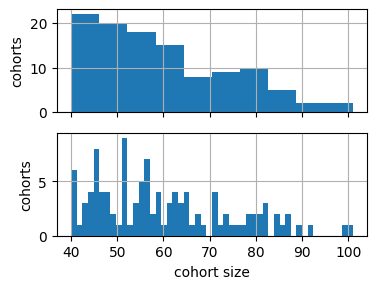

using panel id: 2
cohort sizes:
count    111.000000
mean      60.234234
std       14.673387
min       40.000000
25%       47.500000
50%       56.000000
75%       70.500000
max       92.000000
Name: cohort, dtype: float64


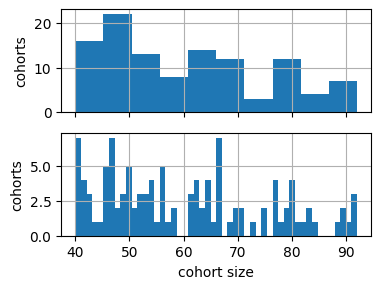

using panel id: 3
cohort sizes:
count    123.000000
mean      56.073171
std       14.255382
min       40.000000
25%       46.000000
50%       53.000000
75%       63.000000
max      115.000000
Name: cohort, dtype: float64


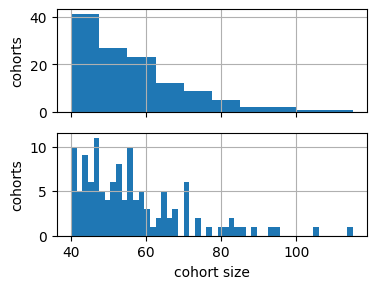

using panel id: 349
cohort sizes:
count    109.000000
mean      58.000000
std       14.566578
min       40.000000
25%       46.000000
50%       54.000000
75%       67.000000
max      100.000000
Name: cohort, dtype: float64


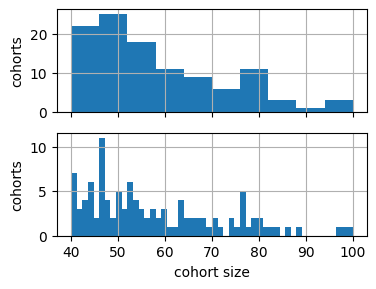

In [43]:
# just one panel at a time

panel_ids = [1, 2, 3, random.choice(all_panels_random_domains_df.panel_id.unique())]
for panel_id in panel_ids:
    print('using panel id: %s' % panel_id)
    panel_df = all_panels_random_domains_df[all_panels_random_domains_df.panel_id == panel_id].copy()
    print('cohort sizes:')
    cohort_counts = panel_df["cohort"].value_counts()
    print(cohort_counts.describe())
    fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
    cohort_counts.hist(ax=ax[0])
    ax[0].set_ylabel('cohorts')
    ax[1].set_ylabel('cohorts')
    _ = ax[1].set_xlabel('cohort size')
    _ = cohort_counts.hist(ax=ax[1], bins=50)
    plt.show()

In [38]:
def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df

dpi = 100
t = 0.1

def plot_cohort_demo_portions(panel_df, demo_col, demo_value_names_dict):
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    
    for val in demo_value_names_dict:
        print('%s' % demo_value_names_dict[val])
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

        fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")

        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        if (demo_fraction - t) > 0:
            ax.hlines(y=demo_fraction-t, xmin=0, xmax=len(ax.get_xticks()), 
                      linestyles='--', color='black', label='mean - t=0.1')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        #ax.legend()
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        ax.set_ylabel('fraction "%s"' % demo_value_names_dict[val])
        plt.show()
    
    return cohort_demo_portions_df

In [39]:
race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
hi_values = {1:'0 to 25k', 2:'25k to 50k', 3:'50k to 100k', 4:'100k +'}
hi_race_values = {
    "1.0, 1.0": "0 to 25k, white",
    "2.0, 1.0": "25k to 50k, white",
    "3.0, 1.0": "50k to 100k, white",
    "4.0, 1.0": "100k +, white",
    
    "1.0, 2.0": "0 to 25k, black",
    "2.0, 2.0": "25k to 50k, black",
    "3.0, 2.0": "50k to 100k, black",
    "4.0, 2.0": "100k +, black",
    
    "1.0, 3.0": "0 to 25k, asian",
    "2.0, 3.0": "25k to 50k, asian",
    "3.0, 3.0": "50k to 100k, asian",
    "4.0, 3.0": "100k +, asian",
    
    "1.0, 5.0": "0 to 25k, other",
    "2.0, 5.0": "25k to 50k, other",
    "3.0, 5.0": "50k to 100k, other",
    "4.0, 5.0": "100k +, other",
}

white
mean fraction white across cohorts = 0.78
fraction white across all users in cohorts = 0.78


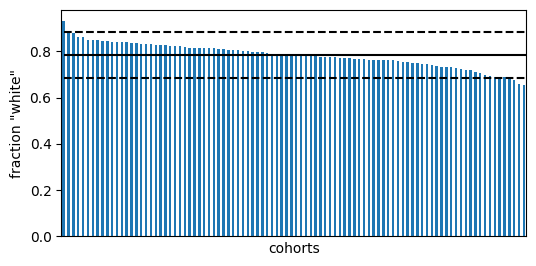

black
mean fraction black across cohorts = 0.14
fraction black across all users in cohorts = 0.13


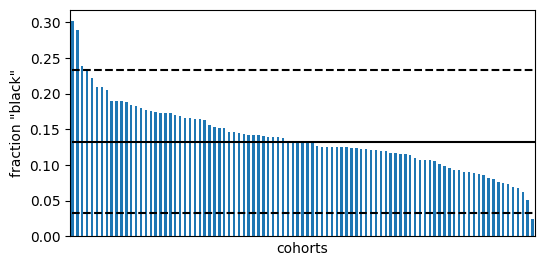

asian
mean fraction asian across cohorts = 0.05
fraction asian across all users in cohorts = 0.05


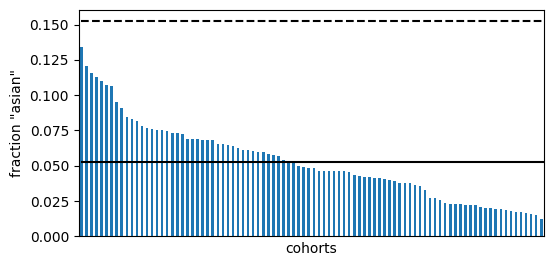

other
mean fraction other across cohorts = 0.03
fraction other across all users in cohorts = 0.03


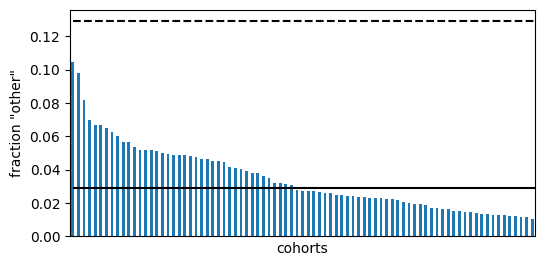

,racial_background,count,total,portion
cohort,,,,
1.0,1.0,38,49,0.775510
1.0,2.0,6,49,0.122449
1.0,3.0,4,49,0.081633
1.0,5.0,1,49,0.020408
2.0,1.0,35,53,0.660377


In [40]:
race = plot_cohort_demo_portions(panel_df, 'racial_background', race_values)
race.head()

0 to 25k
mean fraction 0 to 25k across cohorts = 0.20
fraction 0 to 25k across all users in cohorts = 0.20


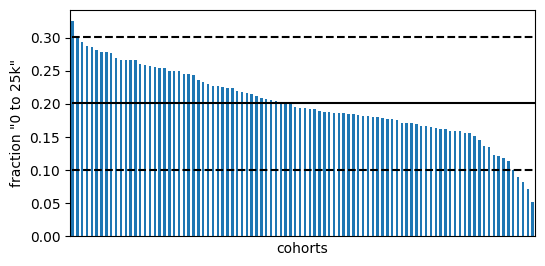

25k to 50k
mean fraction 25k to 50k across cohorts = 0.22
fraction 25k to 50k across all users in cohorts = 0.22


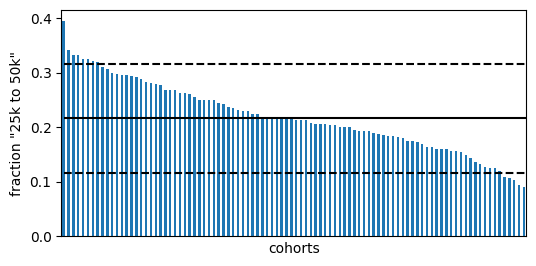

50k to 100k
mean fraction 50k to 100k across cohorts = 0.29
fraction 50k to 100k across all users in cohorts = 0.29


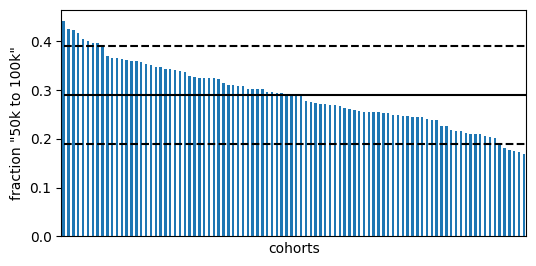

100k +
mean fraction 100k + across cohorts = 0.29
fraction 100k + across all users in cohorts = 0.29


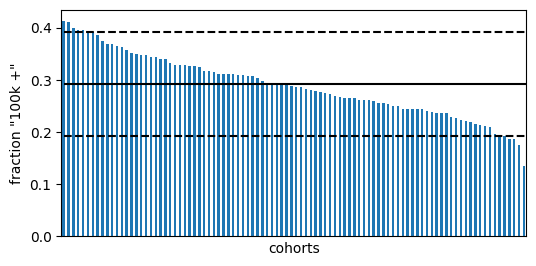

,household_income,count,total,portion
cohort,,,,
1.0,1.0,4,49,0.081633
1.0,2.0,15,49,0.306122
1.0,3.0,17,49,0.346939
1.0,4.0,13,49,0.265306
2.0,1.0,16,53,0.301887


In [41]:
hi = plot_cohort_demo_portions(panel_df, 'household_income', hi_values)
hi.head()

0 to 25k, white
mean fraction 0 to 25k, white across cohorts = 0.14
fraction 0 to 25k, white across all users in cohorts = 0.14


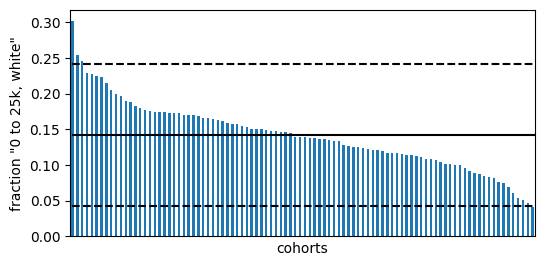

25k to 50k, white
mean fraction 25k to 50k, white across cohorts = 0.17
fraction 25k to 50k, white across all users in cohorts = 0.17


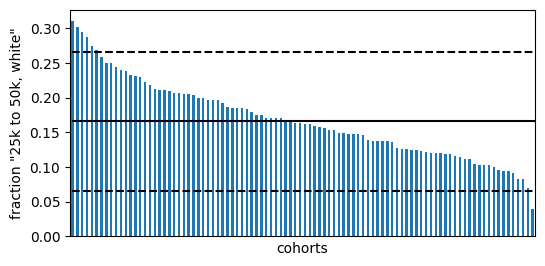

50k to 100k, white
mean fraction 50k to 100k, white across cohorts = 0.23
fraction 50k to 100k, white across all users in cohorts = 0.23


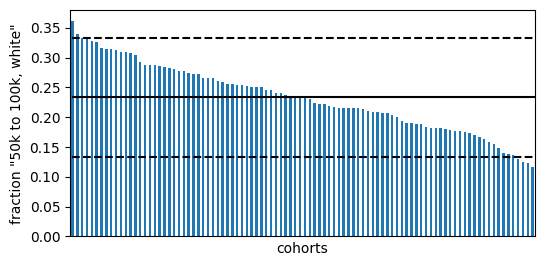

100k +, white
mean fraction 100k +, white across cohorts = 0.24
fraction 100k +, white across all users in cohorts = 0.24


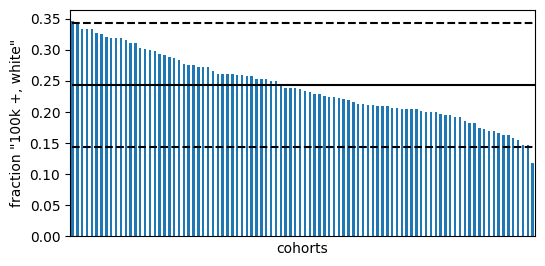

0 to 25k, black
mean fraction 0 to 25k, black across cohorts = 0.05
fraction 0 to 25k, black across all users in cohorts = 0.04


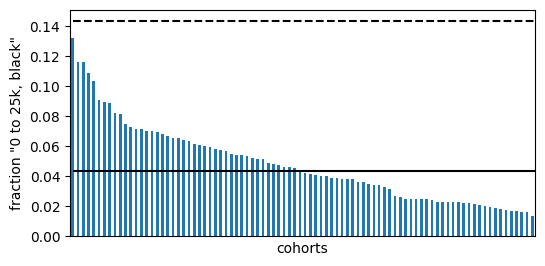

25k to 50k, black
mean fraction 25k to 50k, black across cohorts = 0.04
fraction 25k to 50k, black across all users in cohorts = 0.03


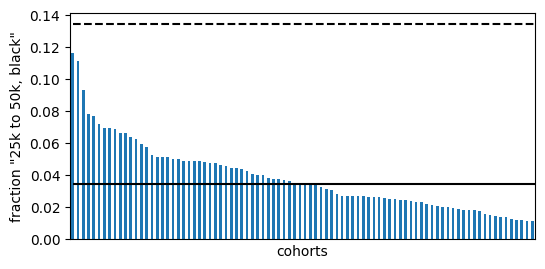

50k to 100k, black
mean fraction 50k to 100k, black across cohorts = 0.04
fraction 50k to 100k, black across all users in cohorts = 0.03


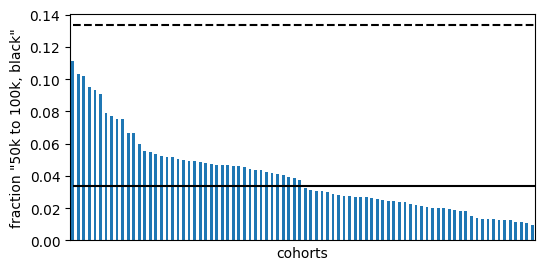

100k +, black
mean fraction 100k +, black across cohorts = 0.03
fraction 100k +, black across all users in cohorts = 0.02


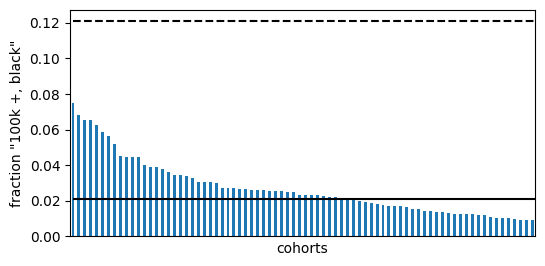

0 to 25k, asian
mean fraction 0 to 25k, asian across cohorts = 0.02
fraction 0 to 25k, asian across all users in cohorts = 0.01


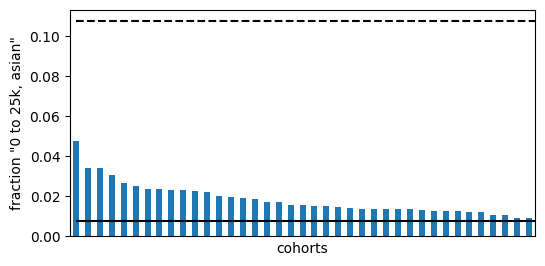

25k to 50k, asian
mean fraction 25k to 50k, asian across cohorts = 0.02
fraction 25k to 50k, asian across all users in cohorts = 0.01


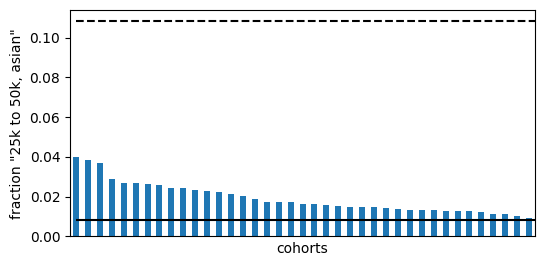

50k to 100k, asian
mean fraction 50k to 100k, asian across cohorts = 0.03
fraction 50k to 100k, asian across all users in cohorts = 0.01


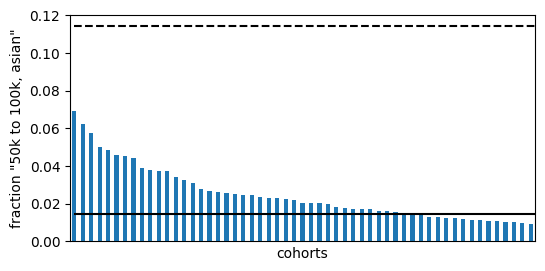

100k +, asian
mean fraction 100k +, asian across cohorts = 0.03
fraction 100k +, asian across all users in cohorts = 0.02


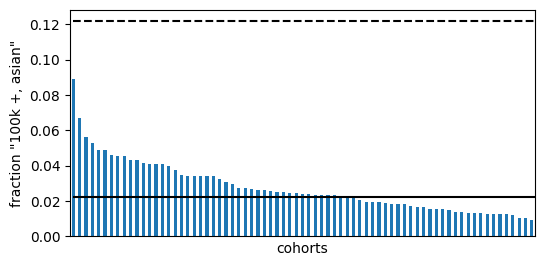

0 to 25k, other
mean fraction 0 to 25k, other across cohorts = 0.02
fraction 0 to 25k, other across all users in cohorts = 0.01


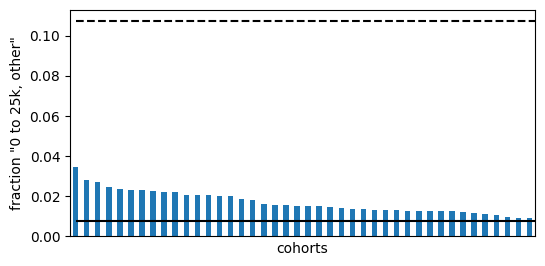

25k to 50k, other
mean fraction 25k to 50k, other across cohorts = 0.02
fraction 25k to 50k, other across all users in cohorts = 0.01


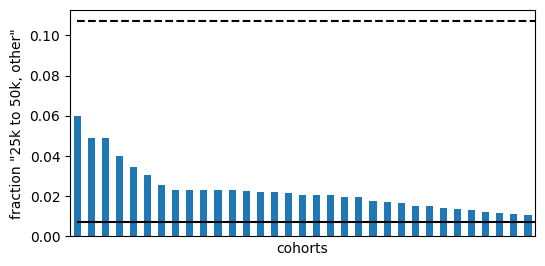

50k to 100k, other
mean fraction 50k to 100k, other across cohorts = 0.02
fraction 50k to 100k, other across all users in cohorts = 0.01


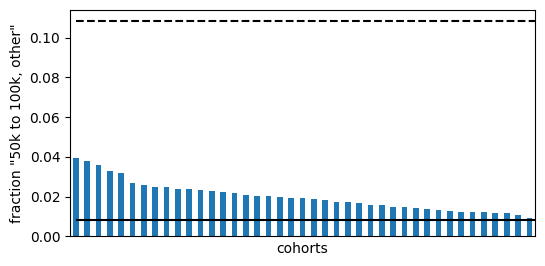

100k +, other
mean fraction 100k +, other across cohorts = 0.02
fraction 100k +, other across all users in cohorts = 0.01


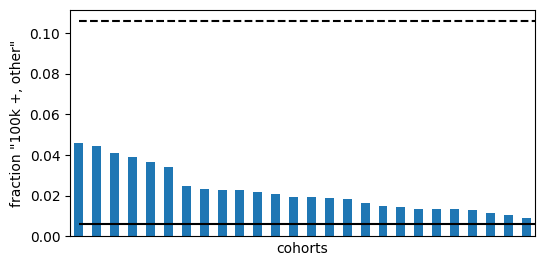

,stratify,count,total,portion
cohort,,,,
1.0,"1.0, 1.0",2,49,0.040816
1.0,"1.0, 2.0",2,49,0.040816
1.0,"2.0, 1.0",12,49,0.244898
1.0,"2.0, 2.0",2,49,0.040816
1.0,"2.0, 3.0",1,49,0.020408
...,...,...,...,...
96.0,"2.0, 5.0",1,43,0.023256
96.0,"3.0, 1.0",9,43,0.209302
96.0,"3.0, 2.0",2,43,0.046512


In [42]:
hi_race = plot_cohort_demo_portions(panel_df, 'stratify', hi_race_values)
hi_race